# Import Modules

In [ ]:
from causalnex.structure.notears import from_pandas
from causalnex.plots import plot_structure, NODE_STYLE, EDGE_STYLE
from IPython.display import Markdown, display, Image, display_html
from sklearn.model_selection import train_test_split
from causalnex.network import BayesianNetwork
import pandas as pd
import warnings
import sys
from sklearn.preprocessing import Normalizer, MinMaxScaler
sys.path.append('../scripts')
from dataframe_handler import HandleDataFrame
warnings.filterwarnings('ignore')

# Initialize the dataframe handler

In [3]:
df_handle = HandleDataFrame()

# Choose Selected Features and extract dataframe
    - Features are selected by using feature importance found from xgBoost classifier as I do not have experise in the field of medicine

In [4]:
df = pd.read_csv('../data/data.csv')
selected_features = ["perimeter_worst","radius_worst","perimeter_mean","concave points_mean","concavity_worst","texture_worst","concave points_worst","area_worst","compactness_se"]
ext_df = df_handle.extract_dataframe(df,selected_features)
ext_df


,perimeter_worst,radius_worst,perimeter_mean,concave points_mean,concavity_worst,texture_worst,concave points_worst,area_worst,compactness_se
0,184.60,25.380,122.80,0.14710,0.7119,17.33,0.2654,2019.0,0.04904
1,158.80,24.990,132.90,0.07017,0.2416,23.41,0.1860,1956.0,0.01308
2,152.50,23.570,130.00,0.12790,0.4504,25.53,0.2430,1709.0,0.04006
3,98.87,14.910,77.58,0.10520,0.6869,26.50,0.2575,567.7,0.07458
4,152.20,22.540,135.10,0.10430,0.4000,16.67,0.1625,1575.0,0.02461
...,...,...,...,...,...,...,...,...,...
564,166.10,25.450,142.00,0.13890,0.4107,26.40,0.2216,2027.0,0.02891
565,155.00,23.690,131.20,0.09791,0.3215,38.25,0.1628,1731.0,0.02423
566,126.70,18.980,108.30,0.05302,0.3403,34.12,0.1418,1124.0,0.03731
567,184.60,25.740,140.10,0.15200,0.9387,39.42,0.2650,1821.0,0.06158


# Scale and Normalize the dataframe

In [5]:
scaled = df_handle.scale_dataframe(ext_df)
normalized = df_handle.normalize_dataframe(scaled)
normalized.insert(loc=0, column='diagnosis', value=df['diagnosis'].map({'M': 1, 'B': 0}).astype(int))
normalized

,diagnosis,perimeter_worst,radius_worst,perimeter_mean,concave points_mean,concavity_worst,texture_worst,concave points_worst,area_worst,compactness_se
0,1,0.375575,0.348861,0.306833,0.410869,0.319546,0.079533,0.512538,0.253282,0.197478
1,1,0.392191,0.440929,0.447382,0.253381,0.140198,0.220552,0.464377,0.316194,0.059083
2,1,0.321287,0.351583,0.376454,0.401694,0.227325,0.227533,0.527674,0.236654,0.179433
3,1,0.171315,0.176258,0.165746,0.371143,0.389442,0.273942,0.628112,0.066730,0.385589
4,1,0.381246,0.390869,0.474528,0.389851,0.240269,0.093204,0.419955,0.256879,0.126282
...,...,...,...,...,...,...,...,...,...,...
564,1,0.348270,0.376734,0.410222,0.417288,0.198282,0.231664,0.460298,0.273614,0.121019
565,1,0.349084,0.375731,0.404804,0.326123,0.172091,0.468508,0.374924,0.254606,0.110620
566,1,0.327264,0.338590,0.383974,0.226978,0.234116,0.507344,0.419716,0.198737,0.226791
567,1,0.328193,0.311139,0.326832,0.370994,0.368192,0.358624,0.447203,0.197431,0.218815


# Create structural model and Plot Causal Graph

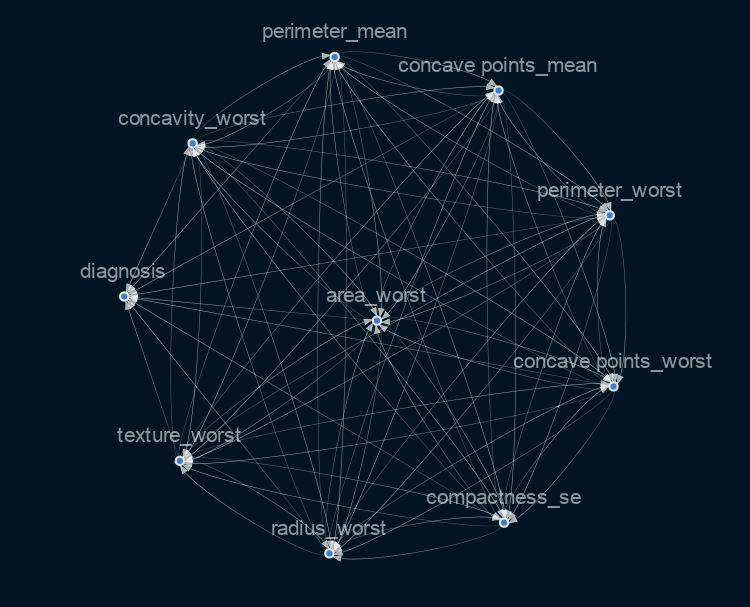

In [6]:
sm = df_handle.create_structural_model(normalized,['diagnosis'])
viz = plot_structure( sm, graph_attributes={"scale": "2.5",  "size": 2.5}, all_node_attributes=NODE_STYLE.WEAK,all_edge_attributes=EDGE_STYLE.WEAK)
Image(viz.draw(format='png'))


# Remove the Graph Edges
    - If we see on the above graph we can see that the graph is highly connected so we can make the connection loose which will enable us to view the direct and indirect variable that affect the outcome (diagnosis in our case).
    - we do this using causalnex's function with threshold

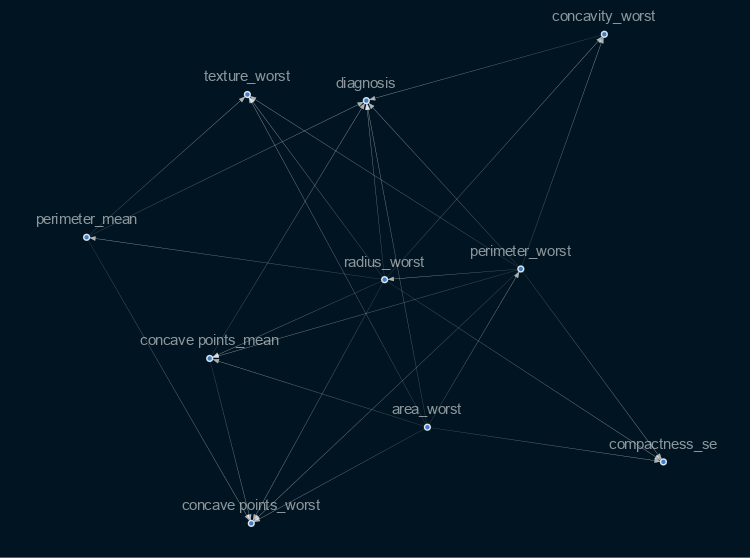

In [7]:
sm.remove_edges_below_threshold(0.8)
viz = plot_structure( sm, graph_attributes={"scale": "2.5",  "size": 2.5}, all_node_attributes=NODE_STYLE.WEAK,all_edge_attributes=EDGE_STYLE.WEAK)
Image(viz.draw(format='png'))

# Graph stability Check
    - We now check if we have a good graph that we can rely on in order to predict using it
    - For this test we will divide the dataframe in to some percentages and view the graphs and after that we will use "jacarand similarity" to check similarity

In [8]:
percentage = 0.5
selected_df = df_handle.select_database_percentage(normalized,percentage)
selected_df

,diagnosis,perimeter_worst,radius_worst,perimeter_mean,concave points_mean,concavity_worst,texture_worst,concave points_worst,area_worst,compactness_se
0,1,0.375575,0.348861,0.306833,0.410869,0.319546,0.079533,0.512538,0.253282,0.197478
1,1,0.392191,0.440929,0.447382,0.253381,0.140198,0.220552,0.464377,0.316194,0.059083
2,1,0.321287,0.351583,0.376454,0.401694,0.227325,0.227533,0.527674,0.236654,0.179433
3,1,0.171315,0.176258,0.165746,0.371143,0.389442,0.273942,0.628112,0.066730,0.385589
4,1,0.381246,0.390869,0.474528,0.389851,0.240269,0.093204,0.419955,0.256879,0.126282
...,...,...,...,...,...,...,...,...,...,...
279,0,0.346913,0.364260,0.453653,0.267884,0.168904,0.376259,0.498754,0.173053,0.143529
280,1,0.354003,0.365000,0.370043,0.312105,0.298632,0.413564,0.418008,0.245746,0.108526
281,0,0.337309,0.378028,0.415615,0.271241,0.106252,0.328491,0.562683,0.169176,0.180504
282,1,0.343101,0.381109,0.389337,0.317726,0.232854,0.299389,0.522735,0.239522,0.100132


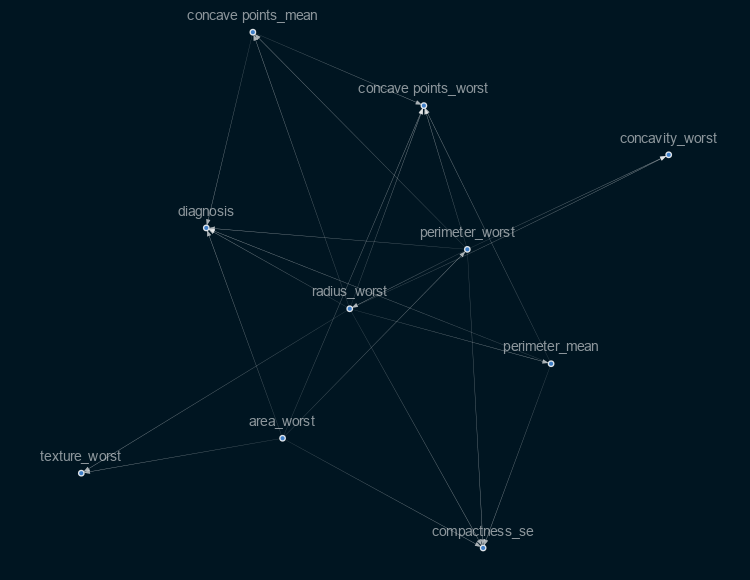

In [9]:
sm_50 = df_handle.create_structural_model_with_threshold(selected_df , ['diagnosis'] , 0.8)
viz_50 = plot_structure( sm_50, graph_attributes={"scale": "2.5",  "size": 2.5}, all_node_attributes=NODE_STYLE.WEAK,all_edge_attributes=EDGE_STYLE.WEAK)
Image(viz_50.draw(format='png'))

In [10]:
percentage = 0.8
selected_df = df_handle.select_database_percentage(normalized,percentage)
selected_df

,diagnosis,perimeter_worst,radius_worst,perimeter_mean,concave points_mean,concavity_worst,texture_worst,concave points_worst,area_worst,compactness_se
0,1,0.375575,0.348861,0.306833,0.410869,0.319546,0.079533,0.512538,0.253282,0.197478
1,1,0.392191,0.440929,0.447382,0.253381,0.140198,0.220552,0.464377,0.316194,0.059083
2,1,0.321287,0.351583,0.376454,0.401694,0.227325,0.227533,0.527674,0.236654,0.179433
3,1,0.171315,0.176258,0.165746,0.371143,0.389442,0.273942,0.628112,0.066730,0.385589
4,1,0.381246,0.390869,0.474528,0.389851,0.240269,0.093204,0.419955,0.256879,0.126282
...,...,...,...,...,...,...,...,...,...,...
450,0,0.202343,0.212215,0.280248,0.145561,0.315488,0.528664,0.369077,0.097138,0.538166
451,1,0.342815,0.370090,0.446507,0.346862,0.244604,0.388714,0.387930,0.233881,0.098536
452,0,0.203577,0.216486,0.268778,0.114007,0.170591,0.812844,0.288393,0.098115,0.209372
453,0,0.350518,0.373971,0.462172,0.431197,0.146484,0.174801,0.490692,0.185385,0.102909


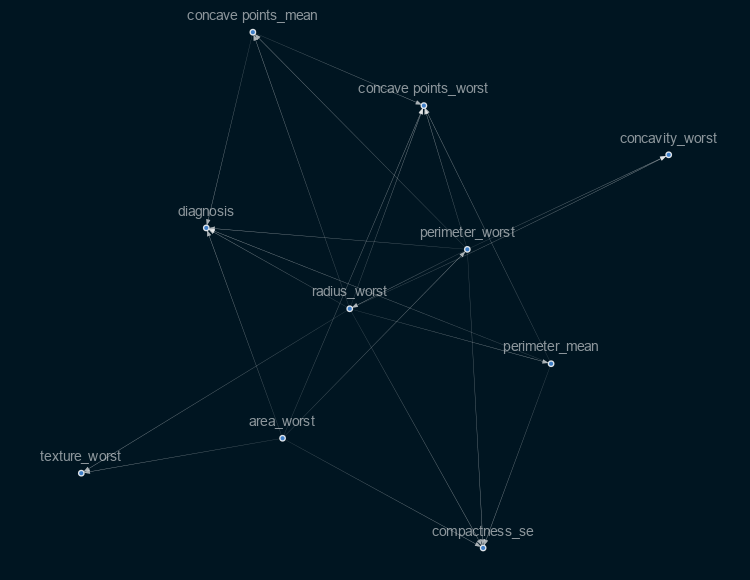

In [11]:
sm_80 = df_handle.create_structural_model_with_threshold(selected_df , ['diagnosis'] , 0.8)
viz_80 = plot_structure( sm_80, graph_attributes={"scale": "2.5",  "size": 2.5}, all_node_attributes=NODE_STYLE.WEAK,all_edge_attributes=EDGE_STYLE.WEAK)
Image(viz_50.draw(format='png'))

In [12]:
percentage = 0.9
selected_df = df_handle.select_database_percentage(normalized,percentage)
selected_df

,diagnosis,perimeter_worst,radius_worst,perimeter_mean,concave points_mean,concavity_worst,texture_worst,concave points_worst,area_worst,compactness_se
0,1,0.375575,0.348861,0.306833,0.410869,0.319546,0.079533,0.512538,0.253282,0.197478
1,1,0.392191,0.440929,0.447382,0.253381,0.140198,0.220552,0.464377,0.316194,0.059083
2,1,0.321287,0.351583,0.376454,0.401694,0.227325,0.227533,0.527674,0.236654,0.179433
3,1,0.171315,0.176258,0.165746,0.371143,0.389442,0.273942,0.628112,0.066730,0.385589
4,1,0.381246,0.390869,0.474528,0.389851,0.240269,0.093204,0.419955,0.256879,0.126282
...,...,...,...,...,...,...,...,...,...,...
507,0,0.227891,0.238435,0.338256,0.378129,0.178825,0.414283,0.582792,0.098968,0.284196
508,0,0.345841,0.390580,0.492148,0.265172,0.181831,0.178877,0.545246,0.213515,0.085866
509,1,0.241698,0.235531,0.299082,0.305406,0.340504,0.467291,0.536079,0.128368,0.255384
510,0,0.243160,0.254564,0.355772,0.207650,0.340148,0.235446,0.574501,0.112292,0.438840


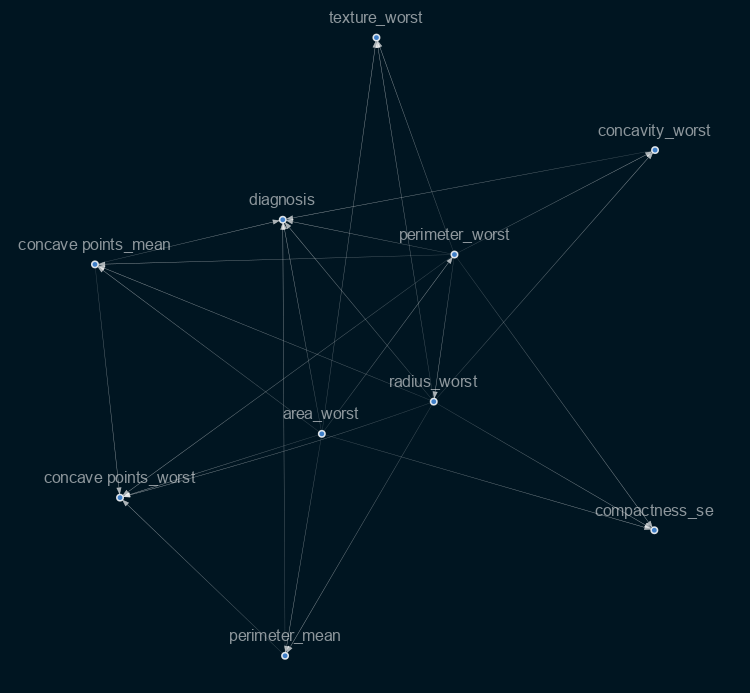

In [13]:
sm_90 = df_handle.create_structural_model_with_threshold(selected_df , ['diagnosis'] , 0.8)
viz_90 = plot_structure( sm_90, graph_attributes={"scale": "2.5",  "size": 2.5}, all_node_attributes=NODE_STYLE.WEAK,all_edge_attributes=EDGE_STYLE.WEAK)
Image(viz_90.draw(format='png'))

## Check Similarity of graphs with "Jacarand Similarity"
    - Jaccard similarity will give as a percentage of how much similar the graphs are and the higher they are the simlilar the graphs hence the graph being stable

In [14]:
df_handle.jaccard_similarity(sm_50.edges, sm_80.edges)

0.8148148148148148

In [15]:
df_handle.jaccard_similarity(sm_90.edges, sm_80.edges)

1.0

In [16]:
df_handle.jaccard_similarity(sm_50.edges, sm_90.edges)

0.8148148148148148

In [17]:
df_handle.jaccard_similarity(sm_90.edges, sm.edges)

0.9259259259259259

# Descritisization of the dataframe
    - Here we will change the dataframe with continues data to discrete
    - we can see below that the values are too much unique which can show that the dataframe consists more of continues data

In [18]:
df_handle.getOverview(df)

,count,none_count,none_percentage,unique_value_count,unique_percentage,dtype
label,,,,,,
id,569,0,0.0%,569,100.0%,int64
symmetry_worst,569,0,0.0%,500,87.87%,float64
concave points_worst,569,0,0.0%,492,86.47%,float64
concavity_worst,569,0,0.0%,539,94.73%,float64
compactness_worst,569,0,0.0%,529,92.97%,float64
smoothness_worst,569,0,0.0%,411,72.23%,float64
area_worst,569,0,0.0%,544,95.61%,float64
perimeter_worst,569,0,0.0%,514,90.33%,float64
texture_worst,569,0,0.0%,511,89.81%,float64


In [19]:
normalized

,diagnosis,perimeter_worst,radius_worst,perimeter_mean,concave points_mean,concavity_worst,texture_worst,concave points_worst,area_worst,compactness_se
0,1,0.375575,0.348861,0.306833,0.410869,0.319546,0.079533,0.512538,0.253282,0.197478
1,1,0.392191,0.440929,0.447382,0.253381,0.140198,0.220552,0.464377,0.316194,0.059083
2,1,0.321287,0.351583,0.376454,0.401694,0.227325,0.227533,0.527674,0.236654,0.179433
3,1,0.171315,0.176258,0.165746,0.371143,0.389442,0.273942,0.628112,0.066730,0.385589
4,1,0.381246,0.390869,0.474528,0.389851,0.240269,0.093204,0.419955,0.256879,0.126282
...,...,...,...,...,...,...,...,...,...,...
564,1,0.348270,0.376734,0.410222,0.417288,0.198282,0.231664,0.460298,0.273614,0.121019
565,1,0.349084,0.375731,0.404804,0.326123,0.172091,0.468508,0.374924,0.254606,0.110620
566,1,0.327264,0.338590,0.383974,0.226978,0.234116,0.507344,0.419716,0.198737,0.226791
567,1,0.328193,0.311139,0.326832,0.370994,0.368192,0.358624,0.447203,0.197431,0.218815


In [20]:
features = df_handle.get_features(ext_df,['diagnosis'])
features

['area_worst',
 'compactness_se',
 'concave points_mean',
 'concave points_worst',
 'concavity_worst',
 'perimeter_mean',
 'perimeter_worst',
 'radius_worst',
 'texture_worst']

In [21]:
extracted_df = df.drop(columns=['Unnamed: 32','id','diagnosis'])
target = df['diagnosis']
target = target.map({'M': 1, 'B': 0}).astype(int)
extracted_df = pd.concat([extracted_df, target], axis=1)
extracted_df

,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,fractal_dimension_mean,...,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst,diagnosis
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.30010,0.14710,0.2419,0.07871,...,17.33,184.60,2019.0,0.16220,0.66560,0.7119,0.2654,0.4601,0.11890,1
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.08690,0.07017,0.1812,0.05667,...,23.41,158.80,1956.0,0.12380,0.18660,0.2416,0.1860,0.2750,0.08902,1
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.19740,0.12790,0.2069,0.05999,...,25.53,152.50,1709.0,0.14440,0.42450,0.4504,0.2430,0.3613,0.08758,1
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.24140,0.10520,0.2597,0.09744,...,26.50,98.87,567.7,0.20980,0.86630,0.6869,0.2575,0.6638,0.17300,1
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.19800,0.10430,0.1809,0.05883,...,16.67,152.20,1575.0,0.13740,0.20500,0.4000,0.1625,0.2364,0.07678,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
564,21.56,22.39,142.00,1479.0,0.11100,0.11590,0.24390,0.13890,0.1726,0.05623,...,26.40,166.10,2027.0,0.14100,0.21130,0.4107,0.2216,0.2060,0.07115,1
565,20.13,28.25,131.20,1261.0,0.09780,0.10340,0.14400,0.09791,0.1752,0.05533,...,38.25,155.00,1731.0,0.11660,0.19220,0.3215,0.1628,0.2572,0.06637,1
566,16.60,28.08,108.30,858.1,0.08455,0.10230,0.09251,0.05302,0.1590,0.05648,...,34.12,126.70,1124.0,0.11390,0.30940,0.3403,0.1418,0.2218,0.07820,1
567,20.60,29.33,140.10,1265.0,0.11780,0.27700,0.35140,0.15200,0.2397,0.07016,...,39.42,184.60,1821.0,0.16500,0.86810,0.9387,0.2650,0.4087,0.12400,1


In [27]:
main_df = ext_df.copy()
main_df['diagnosis'] = extracted_df['diagnosis']
discretised_data = df_handle.change_dataframe_to_discrete(main_df,extracted_df,features)
discretised_data

,perimeter_worst,radius_worst,perimeter_mean,concave points_mean,concavity_worst,texture_worst,concave points_worst,area_worst,compactness_se,diagnosis
0,7,7,7,7,6,1,7,7,7,1
1,7,7,7,4,3,3,7,7,3,1
2,7,7,7,7,6,4,7,7,7,1
3,1,1,0,7,6,4,7,0,7,1
4,7,7,7,7,6,1,6,7,7,1
...,...,...,...,...,...,...,...,...,...,...
564,7,7,7,7,6,4,7,7,7,1
565,7,7,7,7,5,7,6,7,6,1
566,6,6,4,4,5,7,3,6,7,1
567,7,7,7,7,6,7,7,7,7,1


In [43]:
df_handle.getOverview(discretised_data)

,count,none_count,none_percentage,unique_value_count,unique_percentage,dtype
label,,,,,,
perimeter_worst,569,0,0.0%,8,1.41%,int64
radius_worst,569,0,0.0%,8,1.41%,int64
perimeter_mean,569,0,0.0%,8,1.41%,int64
concave points_mean,569,0,0.0%,8,1.41%,int64
concavity_worst,569,0,0.0%,8,1.41%,int64
area_worst,569,0,0.0%,8,1.41%,int64
diagnosis,569,0,0.0%,2,0.35%,int64


# Split the data into train and test data

In [28]:
train, test = train_test_split( discretised_data, train_size=0.8, test_size=0.2, random_state=2021)
train

,perimeter_worst,radius_worst,perimeter_mean,concave points_mean,concavity_worst,texture_worst,concave points_worst,area_worst,compactness_se,diagnosis
269,0,0,0,3,3,4,1,0,7,0
51,1,1,1,0,0,3,1,0,3,0
187,0,1,0,3,0,1,2,0,1,0
28,7,7,4,7,6,7,7,7,7,1
199,6,6,2,4,6,6,7,6,3,1
...,...,...,...,...,...,...,...,...,...,...
44,2,2,1,4,5,6,6,2,3,1
128,3,2,4,6,1,1,3,3,7,0
57,5,4,2,6,5,6,7,6,7,1
341,0,0,0,1,6,3,0,0,7,0


# Create Bayesian Network using Structure model and Likelihood Estimation and Predictions 

In [29]:
sm = df_handle.create_structural_model_with_threshold(normalized , ['diagnosis'] , 0.8)
bn = BayesianNetwork(sm)
bn = bn.fit_node_states(train)
bn = bn.fit_cpds(train, method="BayesianEstimator", bayes_prior="K2")

In [30]:
bn.cpds['perimeter_worst']

area_worst,0,1,2,3,4,5,6,7
perimeter_worst,,,,,,,,
0,0.789916,0.029412,0.090909,0.017544,0.045455,0.111111,0.025641,0.009174
1,0.184874,0.617647,0.090909,0.105263,0.045455,0.111111,0.025641,0.009174
2,0.004202,0.088235,0.272727,0.280702,0.045455,0.111111,0.025641,0.009174
3,0.004202,0.058824,0.090909,0.052632,0.045455,0.111111,0.025641,0.009174
4,0.004202,0.029412,0.090909,0.087719,0.045455,0.111111,0.025641,0.009174
5,0.004202,0.117647,0.181818,0.403509,0.363636,0.222222,0.179487,0.009174
6,0.004202,0.029412,0.090909,0.035088,0.318182,0.111111,0.564103,0.009174
7,0.004202,0.029412,0.090909,0.017544,0.090909,0.111111,0.128205,0.935780


## Predict the values

In [32]:
pred_values = bn.predict(test, 'diagnosis')
true_values = test['diagnosis']
pred_values

,diagnosis_prediction
439,0
561,0
482,0
352,1
550,0
...,...
104,0
299,0
216,0
207,0


## Print Scores 

In [33]:
df_handle.get_scores(true_values,pred_values)

Recall: 0.67
F1: 0.80 
Accuracy: 0.88 
Precision: 1.00 


# Now we will slect the directly connected nodes to the target ('diagnosis') and check if using only those to predict would give us a better result or not
    - We will follow the same procedures as before except the features used here are directly connected node to target on the above graphs

In [34]:
selected_features = ["perimeter_worst","radius_worst","perimeter_mean","concave points_mean","concavity_worst","area_worst",]
ext_last_df = df_handle.extract_dataframe(df,selected_features)
ext_last_df

,perimeter_worst,radius_worst,perimeter_mean,concave points_mean,concavity_worst,area_worst
0,184.60,25.380,122.80,0.14710,0.7119,2019.0
1,158.80,24.990,132.90,0.07017,0.2416,1956.0
2,152.50,23.570,130.00,0.12790,0.4504,1709.0
3,98.87,14.910,77.58,0.10520,0.6869,567.7
4,152.20,22.540,135.10,0.10430,0.4000,1575.0
...,...,...,...,...,...,...
564,166.10,25.450,142.00,0.13890,0.4107,2027.0
565,155.00,23.690,131.20,0.09791,0.3215,1731.0
566,126.70,18.980,108.30,0.05302,0.3403,1124.0
567,184.60,25.740,140.10,0.15200,0.9387,1821.0


In [35]:
last_scaled = df_handle.scale_dataframe(ext_last_df)
last_normalized = df_handle.normalize_dataframe(last_scaled)
last_normalized.insert(loc=0, column='diagnosis', value=df['diagnosis'].map({'M': 1, 'B': 0}).astype(int))
last_normalized

,diagnosis,perimeter_worst,radius_worst,perimeter_mean,concave points_mean,concavity_worst,area_worst
0,1,0.451491,0.419378,0.368854,0.493919,0.384137,0.304479
1,1,0.458329,0.515286,0.522827,0.296110,0.163841,0.369516
2,1,0.402366,0.440308,0.471454,0.503064,0.284692,0.296375
3,1,0.277271,0.285271,0.268258,0.600690,0.630307,0.108001
4,1,0.426512,0.437277,0.530869,0.436138,0.268796,0.287378
...,...,...,...,...,...,...,...
564,1,0.410493,0.444044,0.483514,0.491843,0.233708,0.322499
565,1,0.440611,0.474245,0.510940,0.411630,0.217212,0.321362
566,1,0.456028,0.471811,0.535051,0.316285,0.326230,0.276932
567,1,0.415628,0.394031,0.413904,0.469832,0.466283,0.250029


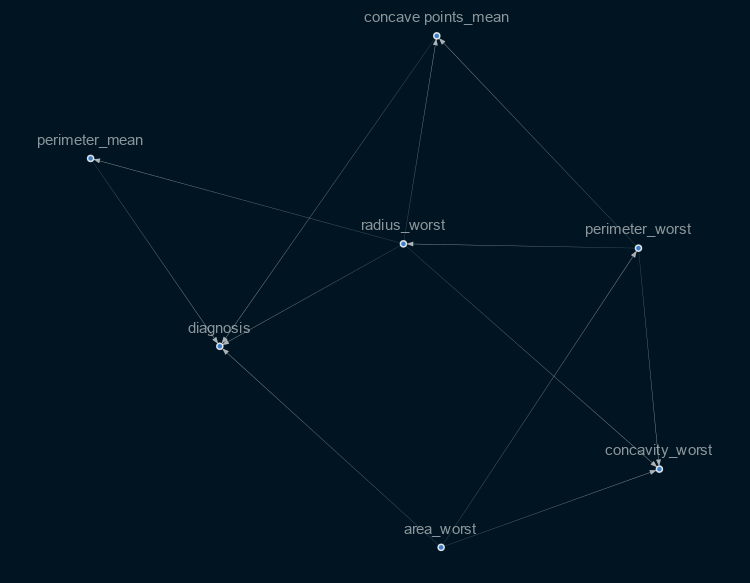

In [36]:
last_sm = df_handle.create_structural_model(last_normalized,['diagnosis'])
last_sm.remove_edges_below_threshold(0.8)
viz = plot_structure( last_sm, graph_attributes={"scale": "2.5",  "size": 2.5}, all_node_attributes=NODE_STYLE.WEAK,all_edge_attributes=EDGE_STYLE.WEAK)
Image(viz.draw(format='png'))

In [37]:
features = df_handle.get_features(ext_last_df,['diagnosis'])
features

['area_worst',
 'concave points_mean',
 'concavity_worst',
 'perimeter_mean',
 'perimeter_worst',
 'radius_worst']

In [38]:
main_df = ext_last_df.copy()
main_df['diagnosis'] = extracted_df['diagnosis']
discretised_data = df_handle.change_dataframe_to_discrete(main_df,extracted_df,features)
discretised_data

,perimeter_worst,radius_worst,perimeter_mean,concave points_mean,concavity_worst,area_worst,diagnosis
0,7,7,7,7,6,7,1
1,7,7,7,4,3,7,1
2,7,7,7,7,6,7,1
3,1,1,0,7,6,0,1
4,7,7,7,7,6,7,1
...,...,...,...,...,...,...,...
564,7,7,7,7,6,7,1
565,7,7,7,7,5,7,1
566,6,6,4,4,5,6,1
567,7,7,7,7,6,7,1


In [39]:
train, test = train_test_split( discretised_data, train_size=0.8, test_size=0.2, random_state=2021)
train

,perimeter_worst,radius_worst,perimeter_mean,concave points_mean,concavity_worst,area_worst,diagnosis
269,0,0,0,3,3,0,0
51,1,1,1,0,0,0,0
187,0,1,0,3,0,0,0
28,7,7,4,7,6,7,1
199,6,6,2,4,6,6,1
...,...,...,...,...,...,...,...
44,2,2,1,4,5,2,1
128,3,2,4,6,1,3,0
57,5,4,2,6,5,6,1
341,0,0,0,1,6,0,0


In [40]:
last_sm = df_handle.create_structural_model_with_threshold(last_normalized , ['diagnosis'] , 0.8)
bn = BayesianNetwork(last_sm)
bn = bn.fit_node_states(train)
bn = bn.fit_cpds(train, method="BayesianEstimator", bayes_prior="K2")

In [41]:
pred_values = bn.predict(test, 'diagnosis')
true_values = test['diagnosis']
pred_values

,diagnosis_prediction
439,0
561,0
482,0
352,1
550,0
...,...
104,0
299,0
216,0
207,0


In [42]:
df_handle.get_scores(true_values,pred_values)

Recall: 0.76
F1: 0.86 
Accuracy: 0.91 
Precision: 1.00 


As we can see here the accuracy has incresed by 3% which means using only those selected features will give us a better prediction model and improve accuracy